# Valuations API Examples

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/ValuationsAPI/ValuationsAPIUse-Cases.ipynb) 

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
pip install signal-ocean

In [1]:
signal_ocean_api_key = '' #replace with your subscription key

## Use Case 1: Average valuation per vessel class.
In this Use Case we will use Valuations API to get latest valuations for tanker vessels and visualize them by vessel class for  vessel classes 84, 85, 86, 87.

### Import helpful modules

In [2]:
from datetime import date, timedelta
from tqdm import tqdm

import requests
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import numpy as np
sns.set_theme()
sns.set_style("whitegrid")

### Get imo numbers for the vessel classes of interest using Vessel API.

### Initialize Vessels API

In [3]:
from signal_ocean import Connection
from signal_ocean.vessels import VesselsAPI

connection = Connection(signal_ocean_api_key)
vessels_api = VesselsAPI(connection)

### Get list of imo numbers per vessel class

In [4]:
vessel_classes = [84, 85, 86, 87]

vessel_class_vessels = {
    vessel_class: [v.imo for v in vessels_api.get_vessels_by_vessel_class(vessel_class)] 
    for vessel_class in vessel_classes
}

### Initialize Vessels API

In [5]:
from signal_ocean.vessel_valuations import VesselValuationsAPI

valuations_api = VesselValuationsAPI(connection)

### Create a list of Vessel Valuations calling Valuations API

In [6]:
vessel_valuations_list = []

for vc, imo_list in vessel_class_vessels.items():
    # Get list of valuation objects for these vessel class
    vessel_class_valuations = valuations_api.get_latest_valuations_for_list_of_vessels(imo_list)
    # Cast vessel valuations to dict objects and add the vessel class key
    vessel_class_valuations = [dict(valuation.to_dict(), **{'vesselClass':vc}) for valuation in vessel_class_valuations]
    # Update the list of all vessels
    vessel_valuations_list.extend(vessel_class_valuations)

valuations_df = pd.DataFrame.from_records(vessel_valuations_list)

### Visuals
#### Create box plots for valuations per vessel class

In [7]:
def set_violins_transparency(violins, alpha):
  for violin in violins.get_children():
    if isinstance(violin, PolyCollection):
      violin.set_alpha(alpha)

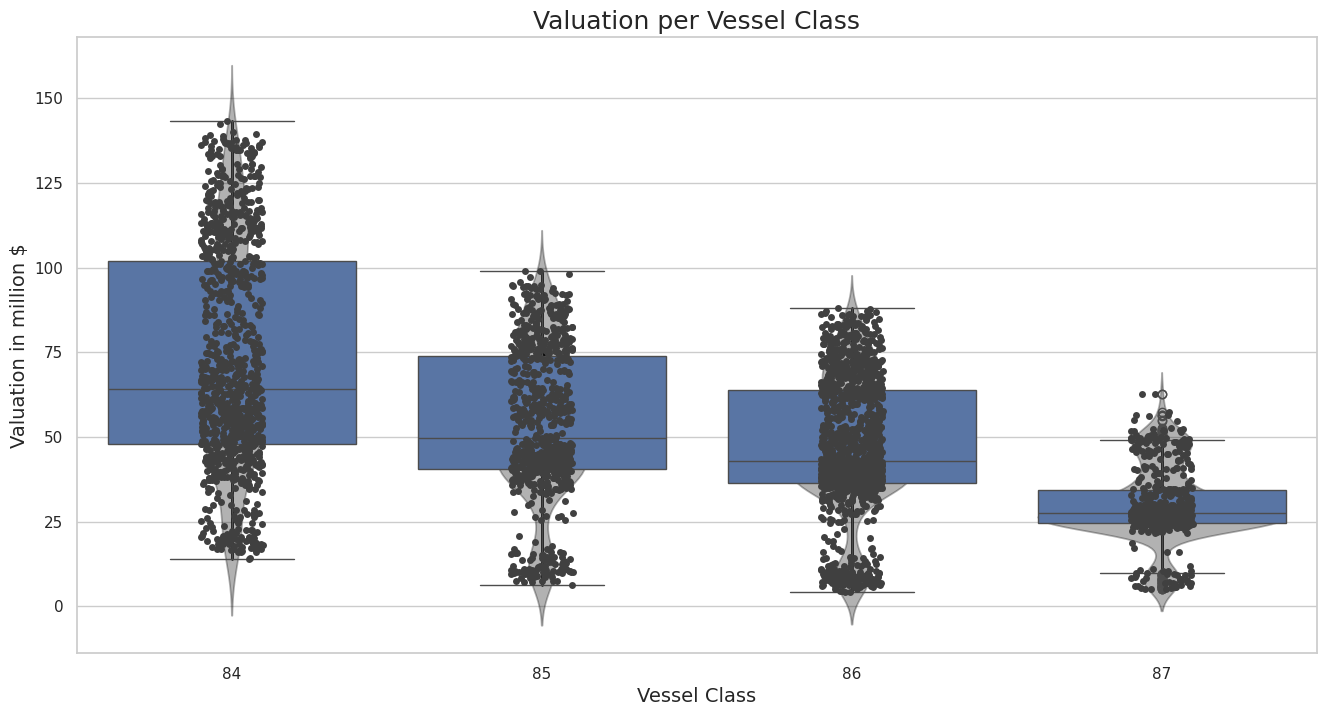

In [8]:
plt.figure(figsize=(16,8))
valuations_df.sort_values('vesselClass', inplace=True)

violins = sns.violinplot(x='vesselClass', y='valuationPrice', data=valuations_df, color=".0")

set_violins_transparency(violins, 0.3)

sns.boxplot(x='vesselClass', y='valuationPrice', data=valuations_df)
sns.stripplot(x='vesselClass', y='valuationPrice', data=valuations_df, color=".25")

plt.ylabel("Valuation in million $", fontsize=14)
plt.xlabel("Vessel Class", fontsize=14)
plt.title("Valuation per Vessel Class", fontsize=18)
plt.show()

## Use Case 2: Historical and Current Vessel Valuation.


### Get historical valuations for 2 tanker vessels and store to Dataframes

In [9]:
vessel_1 = 9453315
valuation_history = valuations_api.get_all_historical_valuations_by_imo(vessel_1)
vessel_1_df = pd.DataFrame.from_records([valuation.to_dict() for valuation in valuation_history])

vessel_2 = 9318084
valuation_history = valuations_api.get_all_historical_valuations_by_imo(vessel_2)
vessel_2_df = pd.DataFrame.from_records([valuation.to_dict() for valuation in valuation_history])

### Feature Engineering
Convert string date column to datetime and save oldest and latest date, valuation and scrap valuation for the 2 vessels

In [10]:
vessel_1_df['valueFrom'] = pd.to_datetime(vessel_1_df['valueFrom'])
vessel_1_oldest_date, vessel_1_latest_date = vessel_1_df['valueFrom'].min(), vessel_1_df['valueFrom'].max()

vessel_1_oldest_valuation = vessel_1_df[vessel_1_df['valueFrom']==vessel_1_oldest_date]['valuationPrice'].iloc[0]
vessel_1_latest_valuation = vessel_1_df[vessel_1_df['valueFrom']==vessel_1_latest_date]['valuationPrice'].iloc[0]

vessel_1_oldest_scrap = vessel_1_df[vessel_1_df['valueFrom']==vessel_1_oldest_date]['scrapPrice'].iloc[0]
vessel_1_latest_scrap = vessel_1_df[vessel_1_df['valueFrom']==vessel_1_latest_date]['scrapPrice'].iloc[0]


vessel_2_df['valueFrom'] = pd.to_datetime(vessel_2_df['valueFrom'])
vessel_2_oldest_date, vessel_2_latest_date = vessel_2_df['valueFrom'].min(), vessel_2_df['valueFrom'].max()

vessel_2_oldest_valuation = vessel_2_df[vessel_2_df['valueFrom']==vessel_2_oldest_date]['valuationPrice'].iloc[0]
vessel_2_latest_valuation = vessel_2_df[vessel_2_df['valueFrom']==vessel_2_latest_date]['valuationPrice'].iloc[0]

vessel_2_oldest_scrap = vessel_2_df[vessel_2_df['valueFrom']==vessel_2_oldest_date]['scrapPrice'].iloc[0]
vessel_2_latest_scrap = vessel_2_df[vessel_2_df['valueFrom']==vessel_2_latest_date]['scrapPrice'].iloc[0]

### Visuals
#### Plot valuations time series.

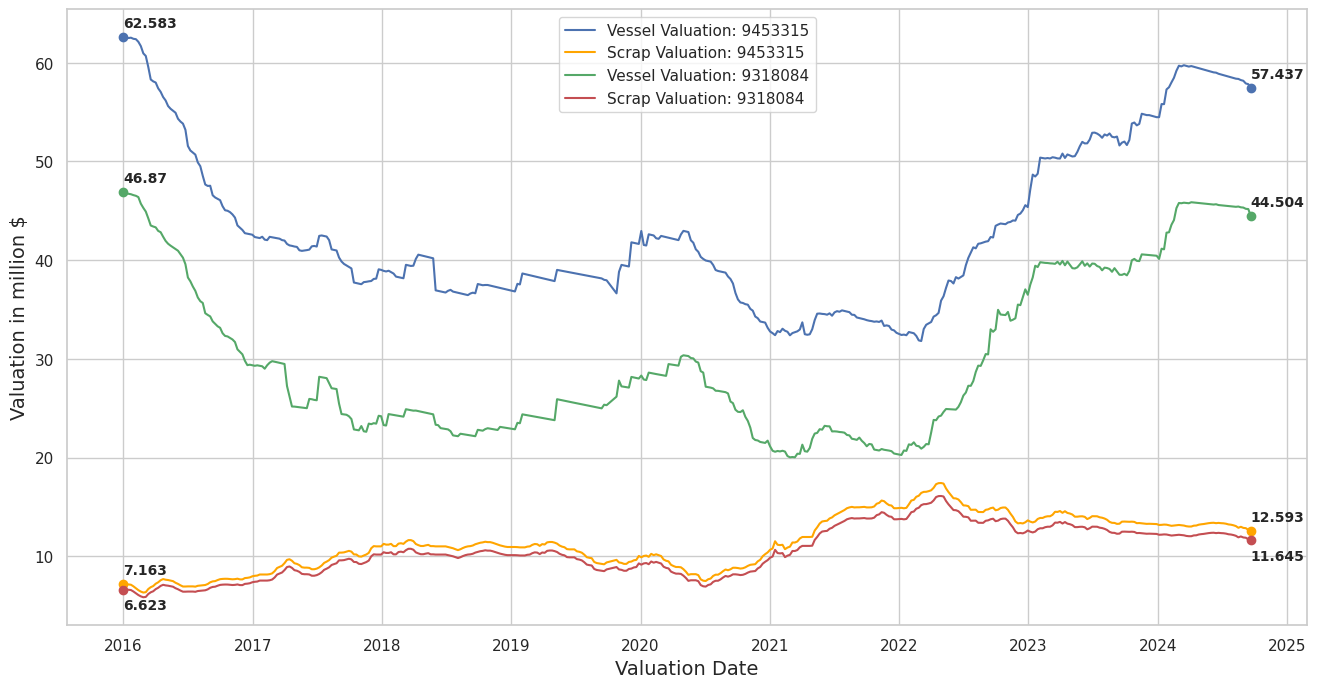

In [11]:
plt.figure(figsize=(16,8))

sns.lineplot(y='valuationPrice', x='valueFrom', data=vessel_1_df, label=f'Vessel Valuation: {vessel_1}', color='b')
plt.scatter(x=vessel_1_oldest_date, y=vessel_1_oldest_valuation, color='b')
plt.scatter(x=vessel_1_latest_date, y=vessel_1_latest_valuation, color='b')
plt.annotate(str(round(vessel_1_oldest_valuation, 3)), xy=(vessel_1_oldest_date, vessel_1_oldest_valuation+1),weight='bold', fontsize=10)
plt.annotate(str(round(vessel_1_latest_valuation, 3)), xy=(vessel_1_latest_date, vessel_1_latest_valuation+1),weight='bold', fontsize=10)

sns.lineplot(y='scrapPrice', x='valueFrom', data=vessel_1_df, label=f'Scrap Valuation: {vessel_1}', color='orange')
plt.scatter(x=vessel_1_oldest_date, y=vessel_1_oldest_scrap, color='orange')
plt.scatter(x=vessel_1_latest_date, y=vessel_1_latest_scrap, color='orange')
plt.annotate(str(round(vessel_1_oldest_scrap, 3)), xy=(vessel_1_oldest_date, vessel_1_oldest_scrap+1),weight='bold', fontsize=10)
plt.annotate(str(round(vessel_1_latest_scrap, 3)), xy=(vessel_1_latest_date, vessel_1_latest_scrap+1),weight='bold', fontsize=10)

sns.lineplot(y='valuationPrice', x='valueFrom', data=vessel_2_df, label=f'Vessel Valuation: {vessel_2}', color='g')
plt.scatter(x=vessel_2_oldest_date, y=vessel_2_oldest_valuation, color='g')
plt.scatter(x=vessel_2_latest_date, y=vessel_2_latest_valuation, color='g')
plt.annotate(str(round(vessel_2_oldest_valuation, 3)), xy=(vessel_2_oldest_date, vessel_2_oldest_valuation+1),weight='bold', fontsize=10)
plt.annotate(str(round(vessel_2_latest_valuation, 3)), xy=(vessel_2_latest_date, vessel_2_latest_valuation+1),weight='bold', fontsize=10)

sns.lineplot(y='scrapPrice', x='valueFrom', data=vessel_2_df, label=f'Scrap Valuation: {vessel_2}', color='r')
plt.scatter(x=vessel_1_oldest_date, y=vessel_2_oldest_scrap, color='r')
plt.scatter(x=vessel_1_latest_date, y=vessel_2_latest_scrap, color='r')
plt.annotate(str(round(vessel_2_oldest_scrap, 3)), xy=(vessel_2_oldest_date, vessel_2_oldest_scrap-2),weight='bold', fontsize=10)
plt.annotate(str(round(vessel_2_latest_scrap, 3)), xy=(vessel_2_latest_date, vessel_2_latest_scrap-2),weight='bold', fontsize=10)


plt.ylabel("Valuation in million $", fontsize=14)
plt.xlabel("Valuation Date", fontsize=14)
plt.show()